In [2]:
import pandas as pd
import os
os.chdir("/Emily/Teaching/Airbnb Austin")
df_full = pd.read_csv('reviews.csv', parse_dates = True, encoding = "utf_8_sig")
df_full.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1078,142,2008-09-13,1344,Amy,A fabulously cozy place! It was slightly diff...
1,1078,207074,2011-03-22,451657,Angela,perfect!---:) Will stay again!
2,1078,217779,2011-04-04,473682,Jenn,I had a great stay at Brian's garden apartment...
3,1078,6841593,2013-08-26,8153398,Kathryn,The reservation was canceled 19 days before ar...
4,1078,7071134,2013-09-05,420381,Rita,Fantastic Experience! My daughter and I staye...


In [3]:
df_full.date = pd.to_datetime(df_full.date)
df_full.date.head()

0   2008-09-13
1   2011-03-22
2   2011-04-04
3   2013-08-26
4   2013-09-05
Name: date, dtype: datetime64[ns]

In [4]:
import numpy as np

In [5]:
dd_start = np.datetime64(min(df_full.date.unique()),'D')
dd_start

numpy.datetime64('2008-09-13')

In [6]:
dd_end = np.datetime64(max(df_full.date.unique()),'D')
dd_end

numpy.datetime64('2019-05-14')

In [7]:
dd_end - dd_start

numpy.timedelta64(3895,'D')

In [8]:
dd_interval = df_full.date - dd_start
dd_interval.head()

0      0 days
1    920 days
2    933 days
3   1808 days
4   1818 days
Name: date, dtype: timedelta64[ns]

In [9]:
num_days = dd_interval.dt.days
num_days.head()

0       0
1     920
2     933
3    1808
4    1818
Name: date, dtype: int64

In [10]:
from matplotlib import pyplot as plt 

[  1.   0.   0. ... 156. 478. 168.]


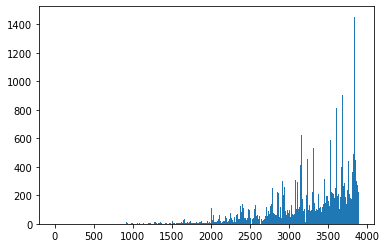

In [11]:
n, x, p = plt.hist(num_days, bins = 3895)
print(n)

In [12]:
a_days = np.arange('2008-09-13', '2019-05-14', dtype='datetime64[D]')

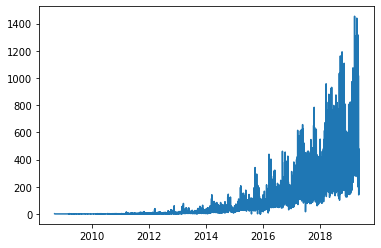

In [13]:
plt.plot(a_days, n)

In [14]:
# Dictionary comprehensions are equally as wonderful as list comprehensions
day_review = {date: val for date, val in zip(a_days, n)}

In [15]:
df0 = pd.DataFrame.from_dict(day_review, orient = 'index', columns = ['n_reviews'])
df0.head()

,n_reviews
2008-09-13,1.0
2008-09-14,0.0
2008-09-15,0.0
2008-09-16,0.0
2008-09-17,0.0


In [16]:
df1 = df0.reset_index()
df1.head()

,index,n_reviews
0,2008-09-13,1.0
1,2008-09-14,0.0
2,2008-09-15,0.0
3,2008-09-16,0.0
4,2008-09-17,0.0


In [17]:
#convert date column into datetime object
df1['index'] = df1['index'].astype('datetime64[ns]')

In [18]:
df2 = df1.resample('W', label='right', closed = 'right', on='index').mean()#sum()
df2.head()

,n_reviews
index,
2008-09-14,0.5
2008-09-21,0.0
2008-09-28,0.0
2008-10-05,0.0
2008-10-12,0.0


<AxesSubplot:xlabel='index'>

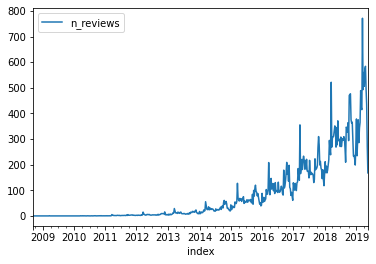

In [19]:
df2.plot()

In [20]:
df_t = df2.loc['2012-06-01':,]
df_w = pd.DataFrame(columns = ['n_reviews'])
df_w.n_reviews = np.log(df_t.n_reviews + 1)
df_w.head()

,n_reviews
index,
2012-06-03,1.665008
2012-06-10,1.386294
2012-06-17,1.455287
2012-06-24,1.386294
2012-07-01,1.488077


<AxesSubplot:xlabel='index'>

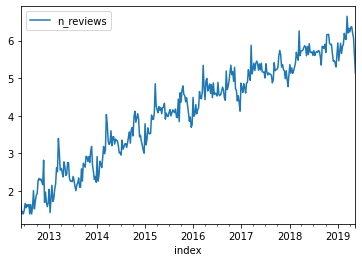

In [21]:
df_w.plot()

## Decompose & Visualize

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

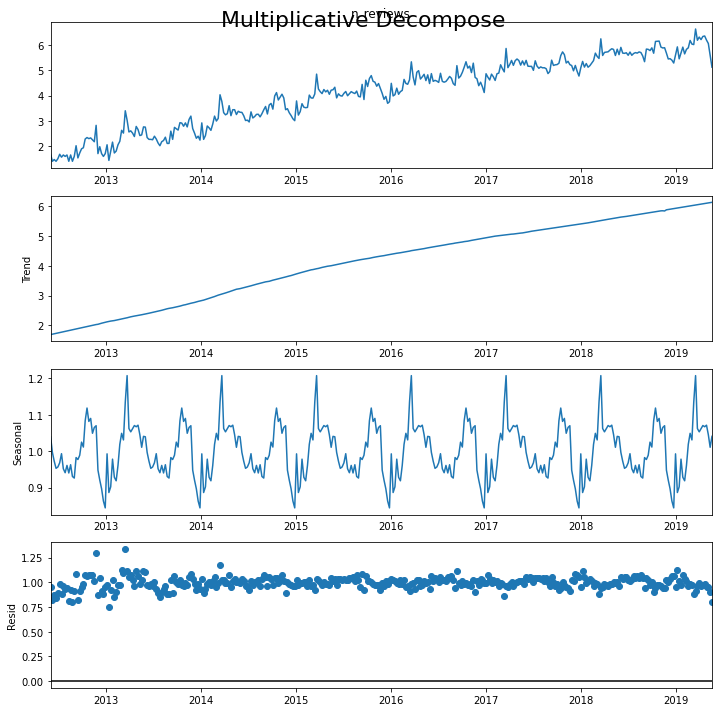

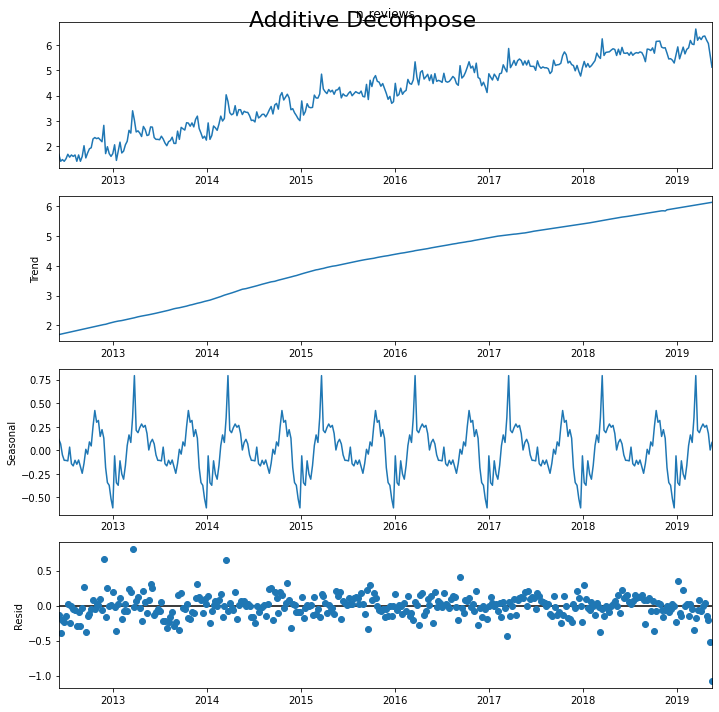

In [24]:
# Multiplicative Decomposition
result_mul = seasonal_decompose(df_w['n_reviews'], model= 'multiplicative', extrapolate_trend= 'freq')
#Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the 
#beginning of the series.
# Additive Decomposition
result_add = seasonal_decompose(df_w['n_reviews'], model= 'additive', extrapolate_trend='freq')
# Plot
plt.rcParams.update({'figure.figsize': (10,10)}) 
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22) 
result_add.plot().suptitle('Additive Decompose', fontsize=22) 
plt.show()

## Cross validation

In [25]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
series = df_w['n_reviews']

In [28]:
historic = series.iloc[:int(len(series) * 0.7)]
test = series.iloc[int(len(series) * 0.7):]

In [29]:
type(historic)

pandas.core.series.Series

In [30]:
historic = historic.to_list()
type(historic)

list

In [31]:
predictions = []
for i in range(len(test)):
    sel = ar_select_order(historic, 13, old_names=False)
    sel.ar_lags
    model_fit = sel.model.fit()
    pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
    predictions.append(pred[0])
    historic.append(test[i])
cross_val = pd.Series(predictions, index=test.index)

In [32]:
test_score = mean_squared_error(test, cross_val, squared = False)
#squared: bool, default=True
#If True returns MSE value, if False returns RMSE value.
print(test_score)

0.21388334736756193


In [33]:
type(cross_val)

pandas.core.series.Series

In [34]:
cross_val.head()

index
2017-04-16    5.273853
2017-04-23    5.250429
2017-04-30    5.339977
2017-05-07    5.363387
2017-05-14    5.400782
Freq: W-SUN, dtype: float64

In [35]:
test

index
2017-04-16    5.204007
2017-04-23    5.389724
2017-04-30    5.456541
2017-05-07    5.395574
2017-05-14    5.212604
                ...   
2019-04-21    6.371612
2019-04-28    6.208590
2019-05-05    6.074689
2019-05-12    5.602119
2019-05-19    5.129899
Freq: W-SUN, Name: n_reviews, Length: 110, dtype: float64

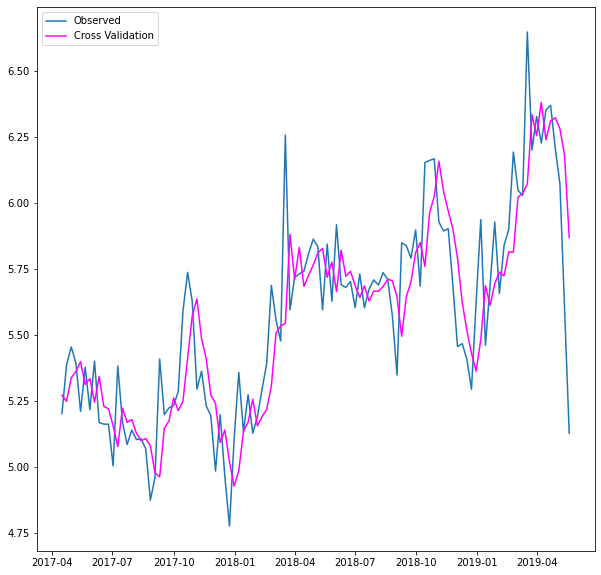

In [36]:
# plot results
plt.plot(test, label='Observed')
plt.plot(cross_val, color='magenta', label='Cross Validation')
plt.legend()
plt.show()

## Prediction for the future

In [37]:
#existing data df_w['n_reviews']
historic = series
#prediction for the next 52 weeks (1 year)
n_pred = 52
#the future weeks starts on 2019-05-26, because the last existing data ends on 2019-05-19
date_pred = pd.date_range("2019-05-26", periods=n_pred, freq="w")

sel = ar_select_order(historic, 13, glob = True, seasonal = True, old_names=False)
sel.ar_lags
model_fit = sel.model.fit()
pred = model_fit.predict(start=len(historic), end=len(historic) + n_pred - 1, dynamic=False)
#The predict function requires a start and an end to be specified, these can be the indexes of the time steps 
#relative to the beginning of the training data used to fit the model
#model_fit.plot_predict(start=len(historic), end=len(historic) + len(test))

In [38]:
predictions = pd.Series(pred.values, index=date_pred)

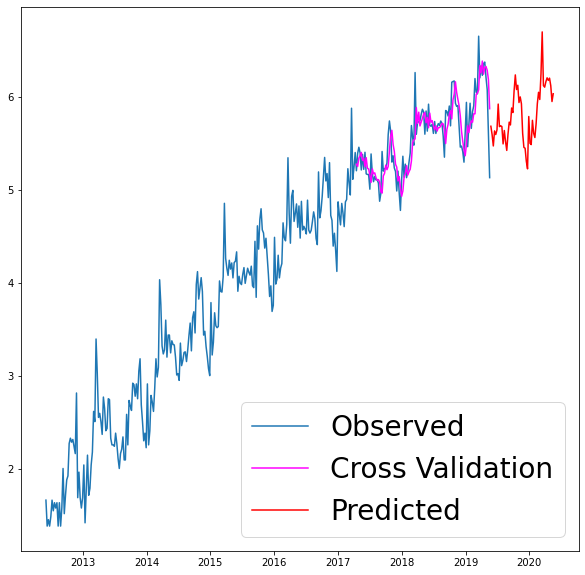

In [39]:
# plot results
plt.plot(series, label='Observed')
plt.plot(cross_val, color='magenta', label='Cross Validation')
plt.plot(predictions, color='red', label='Predicted')
plt.legend(fontsize = 28)
plt.show()